In [ ]:
! git clone https://github.com/SoccerNet/sn-calibration
!mv sn-calibrationa sn_calibration

Cloning into 'sn-calibration'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 196 (delta 37), reused 22 (delta 22), pack-reused 150
Receiving objects: 100% (196/196), 2.66 MiB | 26.68 MiB/s, done.
Resolving deltas: 100% (108/108), done.
mv: cannot stat 'sn-calibrationa': No such file or directory


In [ ]:
!pip install numpy>1.21 torch>=1.13.0 torchvision==0.11.1 pillow>9.0.0 tqdm==4.62.3 SoccerNet>=0.1.23 opencv-python>=4.5.5 matplotlib==3.5.1

In [ ]:
! pip install Pillow
! pip install matplotlib==3.1.3
! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Download datasets to validate and test
from SoccerNet.Downloader import SoccerNetDownloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="soccernet_data")
mySoccerNetDownloader.downloadDataTask(task="calibration", split=["test"])

In [ ]:
!unzip soccernet_data/calibration/test.zip -d soccernet_data/calibration

Streaming output truncated to the last 5000 lines.
  inflating: soccernet_data/calibration/test/00219.jpg  
  inflating: soccernet_data/calibration/test/00219.json  
  inflating: soccernet_data/calibration/test/00220.jpg  
  inflating: soccernet_data/calibration/test/00220.json  
  inflating: soccernet_data/calibration/test/00221.jpg  
  inflating: soccernet_data/calibration/test/00221.json  
  inflating: soccernet_data/calibration/test/00222.jpg  
  inflating: soccernet_data/calibration/test/00222.json  
  inflating: soccernet_data/calibration/test/00223.jpg  
  inflating: soccernet_data/calibration/test/00223.json  
  inflating: soccernet_data/calibration/test/00224.jpg  
  inflating: soccernet_data/calibration/test/00224.json  
  inflating: soccernet_data/calibration/test/00225.jpg  
  inflating: soccernet_data/calibration/test/00225.json  
  inflating: soccernet_data/calibration/test/00226.jpg  
  inflating: soccernet_data/calibration/test/00226.json  
  inflating: soccernet_data/c

In [ ]:
##### import all modules

import os
import glob
from sn_calibration.src.soccerpitch import SoccerPitch
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn.functional as F
import numpy as np
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append("sn_calibration")


from sn_calibration.src.dataloader import SoccerNetDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
### Config

num_classes=29
width = 640
height = 384 
# width = 960
# height = 544 
mean = np.array([0.34682554, 0.48224099, 0.20943351])
std = np.array([0.13307492, 0.17518853, 0.15858151])
batch_size = 5

  0%|                                                                                                                                  | 0/2719 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


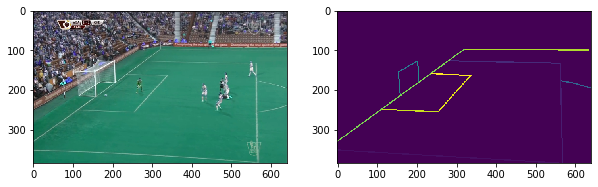

  0%|                                                                                                                          | 1/2719 [00:00<34:10,  1.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


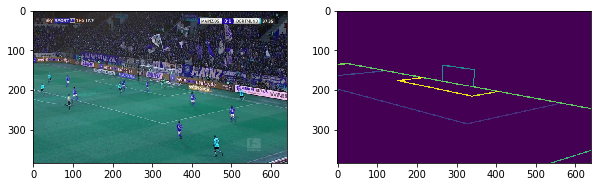

  0%|                                                                                                                          | 2/2719 [00:01<28:56,  1.56it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


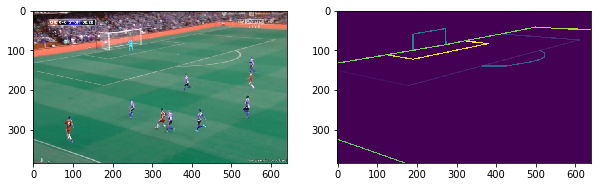

  0%|▏                                                                                                                         | 3/2719 [00:01<26:40,  1.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


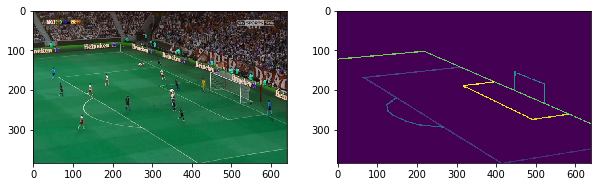

  0%|▏                                                                                                                         | 4/2719 [00:02<25:53,  1.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


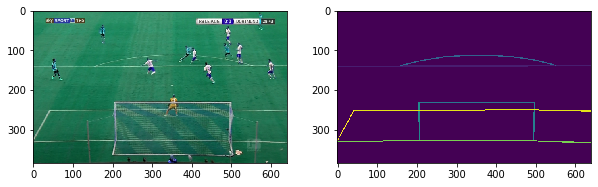

  0%|▏                                                                                                                         | 4/2719 [00:02<33:24,  1.35it/s]


In [ ]:
dataset_path = "soccernet_data/calibration"
soccernet = SoccerNetDataset(dataset_path, split="test", width=width, height=height, mean="sn_calibration/resources/mean.npy", std="sn_calibration/resources/std.npy")
test_dataloader = DataLoader(soccernet, batch_size=batch_size, shuffle=True)

dataset_dir = os.path.join(dataset_path, "test")

with tqdm(enumerate(soccernet), total=len(soccernet), ncols=160) as t:
    for i, data in t:
        img = soccernet[i][0].transpose((1, 2, 0))*soccernet.std + soccernet.mean
        fig, axs = plt.subplots(1,2,figsize=(10,10))
        axs[0].imshow(img)
        axs[1].imshow(soccernet[i][1].astype(np.uint8))
        plt.show()

        if i > 3: 
          break

In [ ]:
### Load network Unet + MobileNetV2
### Download weights of model from my source :)

model = torch.load("net.pt", map_location=device)
model.eval()
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [ ]:
## count Metrics (Approximately 30 min)
## mIoU 52.2 Accuracy 98.5 on test datasets on my runs

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=29):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

In [ ]:
model.eval()
test_loss = 0
test_accuracy = 0
val_iou_score = 0
# validation loop
with torch.no_grad():
    for i, data in enumerate(tqdm(test_dataloader)):
        # reshape to 9 patches from single image, delete batch size
        image_tiles, mask_tiles = data
        image = image_tiles.to(device);
        mask = mask_tiles.to(device).long();
        output = model(image)
        # evaluation metrics
        val_iou_score += mIoU(output, mask)
        test_accuracy += pixel_accuracy(output, mask)
        # loss
        loss = criterion(output, mask)
        test_loss += loss.item()


# iou
print("Val mIoU: {:.3f}..".format(val_iou_score / len(test_dataloader)),
      "Val Acc:{:.3f}..".format(test_accuracy / len(test_dataloader)))

 11%|█         | 59/544 [04:12<34:39,  4.29s/it]


KeyboardInterrupt: ignored

In [ ]:
### segmentate some images

In [ ]:
sample_idx = 102

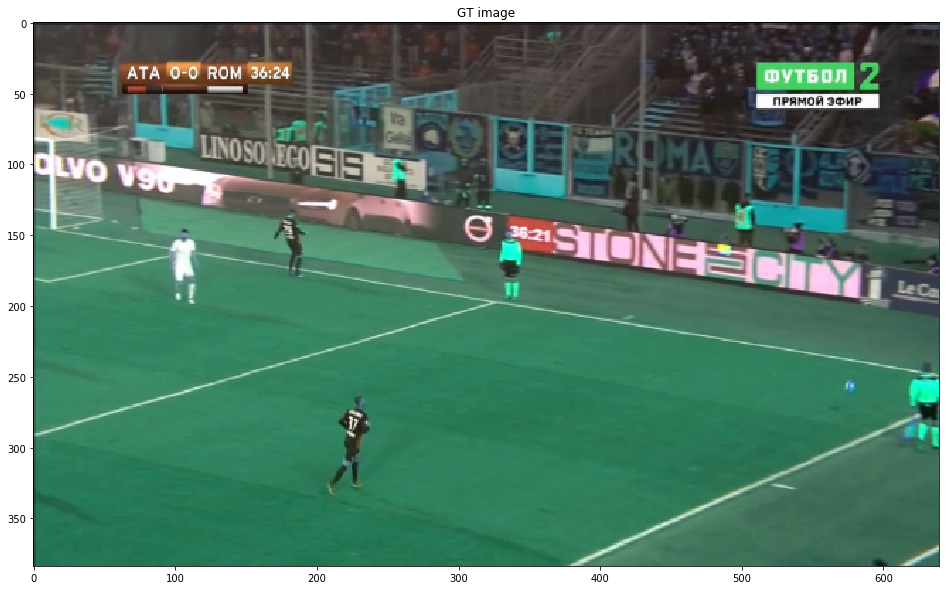

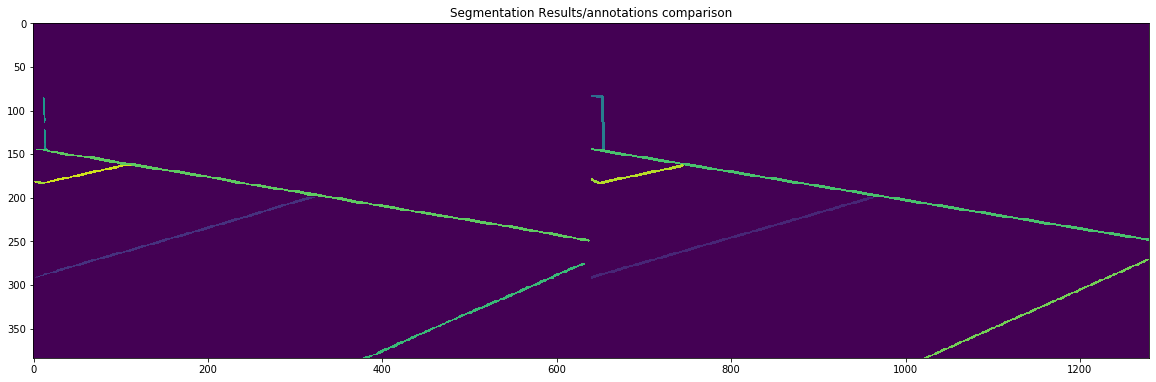

In [ ]:
img, mask = soccernet[sample_idx]

img_gt = img.transpose(1,2,0)*soccernet.std + soccernet.mean

img_t = torch.from_numpy(img).to(device)[None,...]

output = model(img_t)

out_mask = output.permute(0,2,3,1).argmax(dim=-1)[0]

vis = np.concatenate((out_mask.cpu().numpy(), mask), axis=1)

plt.figure(figsize=(20,10))
plt.title("GT image")
plt.imshow(img_gt)
plt.savefig("GT.png")
plt.show()

plt.figure(figsize=(20,10))
plt.title("Segmentation Results/annotations comparison")
plt.imshow(vis)
plt.savefig("segmentation_annotation.png")
plt.show()

In [ ]:
from sn_calibration.src.baseline_extremities import *
from sn_calibration.src.soccerpitch import SoccerPitch

In [ ]:
lines_palette = [0, 0, 0]
for line_class in SoccerPitch.lines_classes:
  lines_palette.extend(SoccerPitch.palette[line_class])

In [ ]:
output_semlines = out_mask.cpu().numpy().astype(np.uint8)
output_semlines.shape

(384, 640)

In [ ]:
def generate_class_synthesis(semantic_mask, radius):
    """
    This function selects for each class present in the semantic mask, a set of circles that cover most of the semantic
    class blobs.
    :param semantic_mask: a image containing the segmentation predictions
    :param radius: circle radius
    :return: a dictionary which associates with each class detected a list of points ( the circles centers)
    """
    buckets = dict()
    # kernel = np.ones((5, 5), np.uint8)
    # semantic_mask = cv.erode(semantic_mask, kernel, iterations=1)
    for k, class_name in enumerate(SoccerPitch.lines_classes):
        mask = semantic_mask == k + 1
        if mask.sum() > 0:
            disk_list = synthesize_mask(mask, radius)
            if len(disk_list):
                buckets[class_name] = disk_list

    return buckets

In [ ]:
skeletons = generate_class_synthesis(output_semlines, 6)

In [ ]:
extrimities_frame = np.zeros_like(img_gt).astype(np.uint8)

for line_class, pts in skeletons.items():
  color = SoccerPitch.palette[line_class]
  for pt in pts:
    x,y = pt
    cv2.circle(extrimities_frame,(y, x), 10, color, -1)

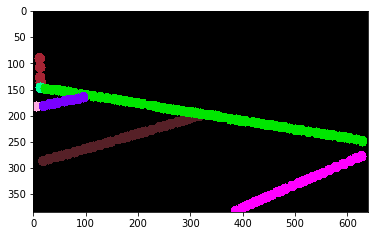

In [ ]:
plt.figure()
plt.imshow(extrimities_frame)
plt.savefig("circles.png")
plt.show()

In [ ]:
extremities = get_line_extremities(skeletons, 40, 640, 384)
extremities

{'Big rect. right bottom': [{'x': 0.4953125, 'y': 0.5208333333333334},
  {'x': 0.0296875, 'y': 0.7447916666666666}],
 'Goal right post right': [{'x': 0.021875, 'y': 0.3541666666666667},
  {'x': 0.01875, 'y': 0.234375}],
 'Side line bottom': [{'x': 0.60625, 'y': 0.9921875},
  {'x': 0.9796875, 'y': 0.7213541666666666}],
 'Side line left': [{'x': 0.021875, 'y': 0.3802083333333333},
  {'x': 0.021875, 'y': 0.3802083333333333}],
 'Side line right': [{'x': 0.0375, 'y': 0.3854166666666667},
  {'x': 0.9828125, 'y': 0.6458333333333334}],
 'Small rect. left main': [{'x': 0.009375, 'y': 0.4739583333333333},
  {'x': 0.009375, 'y': 0.4739583333333333}],
 'Small rect. right bottom': [{'x': 0.03125, 'y': 0.4713541666666667},
  {'x': 0.15, 'y': 0.4270833333333333}]}

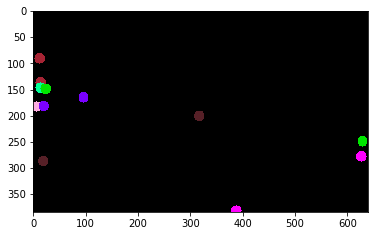

In [ ]:
extremities_corner_frames = np.zeros_like(img_gt).astype(np.uint8)

for line_class, pts in extremities.items():
  color = SoccerPitch.palette[line_class]
  for pt in pts:
    x,y = pt["x"], pt["y"]
    x = int(x*width)
    y = int(y*height)
    cv2.circle(extremities_corner_frames,(x, y), 10, color, -1)

plt.figure()
plt.imshow(extremities_corner_frames)
plt.savefig("extremities.png")
plt.show()

In [ ]:
### Full eval on test dataset
frames = [f for f in os.listdir(dataset_dir) if ".jpg" in f]
frames = frames[::10]


with tqdm(enumerate(frames), total=len(frames), ncols=160) as t:
    for i, frame in t:

        output_prediction_folder = os.path.join("prediction", "test")
        if not os.path.exists(output_prediction_folder):
            os.makedirs(output_prediction_folder)
        prediction = dict()
        count = 0

        frame_path = os.path.join(dataset_dir, frame)
        frame_index = frame.split(".")[0]

        image = cv2.imread(frame_path)
        image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
        image = np.asarray(image, np.float32) / 255.
        image -= soccernet.mean
        image /= soccernet.std
        image = image.transpose((2, 0, 1))
        img_t = torch.from_numpy(image).to(device)[None,...]

        output = model(img_t)
        out_mask = output.permute(0,2,3,1).argmax(dim=-1)[0]
        output_semlines = out_mask.cpu().numpy().astype(np.uint8)


        if True:
            mask = Image.fromarray(output_semlines.astype(np.uint8)).convert('P')
            mask.putpalette(lines_palette)
            mask_file = os.path.join(output_prediction_folder, frame)
            mask.convert('RGB').save(mask_file)
        skeletons = generate_class_synthesis(output_semlines, 6)
        extremities = get_line_extremities(skeletons, 40, 640, 384)

        prediction = extremities
        count += 1

        prediction_file = os.path.join(output_prediction_folder, f"extremities_{frame_index}.json")
        with open(prediction_file, "w") as f:
            json.dump(prediction, f, indent=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [07:38<00:00,  1.68s/it]


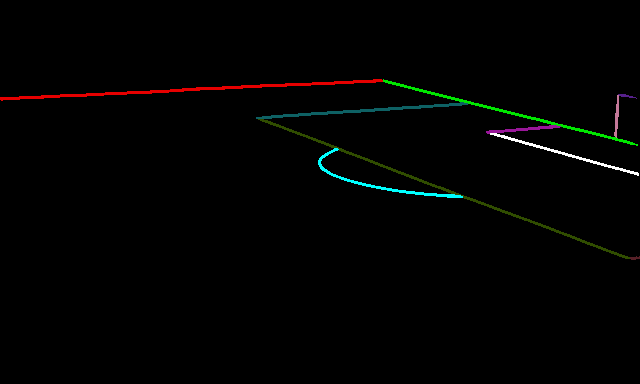

In [ ]:
mask

In [ ]:
from sn_calibration.src.evaluate_extremities import *

In [ ]:
threshold = 5
split = "test"


accuracies = []
precisions = []
recalls = []
dict_errors = {}
per_class_confusion_dict = {}

# annotation_files = [f for f in os.listdir(dataset_dir) if ".json" in f]
annotation_files = [frame[:-4] + ".json" for frame in frames]

with tqdm(enumerate(annotation_files), total=len(annotation_files), ncols=160) as t:
    for i, annotation_file in t:
        frame_index = annotation_file.split(".")[0]
        annotation_file = os.path.join(dataset_dir, annotation_file)
        prediction_file = os.path.join("prediction", "test", f"extremities_{frame_index}.json")

        if not os.path.exists(prediction_file):
            accuracies.append(0.)
            precisions.append(0.)
            recalls.append(0.)
            continue

        with open(annotation_file, 'r') as f:
            line_annotations = json.load(f)

        with open(prediction_file, 'r') as f:
            predictions = json.load(f)

        predictions = scale_points(predictions, width, height)
        line_annotations = scale_points(line_annotations, width, height)

        img_prediction = predictions
        img_groundtruth = line_annotations
        confusion1, per_class_conf1, reproj_errors1 = evaluate_detection_prediction(img_prediction,
                                                                                    img_groundtruth,
                                                                                    threshold)
        confusion2, per_class_conf2, reproj_errors2 = evaluate_detection_prediction(img_prediction,
                                                                                    mirror_labels(
                                                                                    img_groundtruth),
                                                                                    threshold)

        accuracy1, accuracy2 = 0., 0.
        if confusion1.sum() > 0:
            accuracy1 = confusion1[0, 0] / confusion1.sum()

        if confusion2.sum() > 0:
            accuracy2 = confusion2[0, 0] / confusion2.sum()

        if accuracy1 > accuracy2:
            accuracy = accuracy1
            confusion = confusion1
            per_class_conf = per_class_conf1
            reproj_errors = reproj_errors1
        else:
            accuracy = accuracy2
            confusion = confusion2
            per_class_conf = per_class_conf2
            reproj_errors = reproj_errors2

        accuracies.append(accuracy)
        if confusion[0, :].sum() > 0:
            precision = confusion[0, 0] / (confusion[0, :].sum())
            precisions.append(precision)
        if (confusion[0, 0] + confusion[1, 0]) > 0:
            recall = confusion[0, 0] / (confusion[0, 0] + confusion[1, 0])
            recalls.append(recall)

        for line_class, errors in reproj_errors.items():
            if line_class in dict_errors.keys():
                dict_errors[line_class].extend(errors)
            else:
                dict_errors[line_class] = errors

        for line_class, confusion_mat in per_class_conf.items():
            if line_class in per_class_confusion_dict.keys():
                per_class_confusion_dict[line_class] += confusion_mat
            else:
                per_class_confusion_dict[line_class] = confusion_mat

mRecall = np.mean(recalls)
sRecall = np.std(recalls)
medianRecall = np.median(recalls)
print(
    f" On SoccerNet {split} set, recall mean value : {mRecall * 100:2.2f}% with standard deviation of {sRecall * 100:2.2f}% and median of {medianRecall * 100:2.2f}%")

mPrecision = np.mean(precisions)
sPrecision = np.std(precisions)
medianPrecision = np.median(precisions)
print(
    f" On SoccerNet {split} set, precision mean value : {mPrecision * 100:2.2f}% with standard deviation of {sPrecision * 100:2.2f}% and median of {medianPrecision * 100:2.2f}%")

mAccuracy = np.mean(accuracies)
sAccuracy = np.std(accuracies)
medianAccuracy = np.median(accuracies)
print(
    f" On SoccerNet {split} set, accuracy mean value : {mAccuracy * 100:2.2f}% with standard deviation of {sAccuracy * 100:2.2f}% and median of {medianAccuracy * 100:2.2f}%")

for line_class, confusion_mat in per_class_confusion_dict.items():
    class_accuracy = confusion_mat[0, 0] / confusion_mat.sum()
    class_recall = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[1, 0])
    class_precision = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    print(
        f"For class {line_class}, accuracy of {class_accuracy * 100:2.2f}%, precision of {class_precision * 100:2.2f}%  and recall of {class_recall * 100:2.2f}%")

for k, v in dict_errors.items():
    fig, ax1 = plt.subplots(figsize=(11, 8))
    ax1.hist(v, bins=30, range=(0, 60))
    ax1.set_title(k)
    ax1.set_xlabel("Errors in pixel")
    os.makedirs(f"./results/", exist_ok=True)
    plt.savefig(f"./results/{k}_detection_error.png")
    plt.close(fig)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 796.59it/s]


 On SoccerNet test set, recall mean value : 82.19% with standard deviation of 32.62% and median of 100.00%
 On SoccerNet test set, precision mean value : 29.13% with standard deviation of 16.93% and median of 33.33%
 On SoccerNet test set, accuracy mean value : 28.65% with standard deviation of 17.05% and median of 33.33%
For class Big rect. left main, accuracy of 22.10%, precision of 23.11%  and recall of 83.56%
For class Big rect. left bottom, accuracy of 38.73%, precision of 41.67%  and recall of 84.62%
For class Side line top, accuracy of 51.15%, precision of 51.74%  and recall of 97.80%
For class Goal left post right, accuracy of 26.59%, precision of 27.69%  and recall of 87.01%
For class Side line left, accuracy of 22.70%, precision of 23.63%  and recall of 85.19%
For class Small rect. left main, accuracy of 21.38%, precision of 21.68%  and recall of 93.94%
For class Small rect. left bottom, accuracy of 27.94%, precision of 29.08%  and recall of 87.69%
For class Circle left, accu

In [ ]:
from sn_calibration.src.baseline_cameras import *

In [ ]:
def draw_pitch_homography(image, homography):
    """
    Draws points along the soccer pitch markings elements in the image based on the homography projection.
    /!\ This function assumes that the resolution of the image is 540p.
    :param image
    :param homography: homography that captures the relation between the world pitch plane and the image
    :return: modified image
    """
    field = SoccerPitch()
    polylines = field.sample_field_points()
    for line in polylines.values():

        for point in line:
            if point[2] == 0.:
                hp = np.array((point[0], point[1], 1.))
                projected = homography @ hp
                if projected[2] == 0.:
                    continue
                projected /= projected[2]
                if 0 < projected[0] < width and 0 < projected[1] < height:
                    cv.circle(image, (int(projected[0]), int(projected[1])), 1, (255, 0, 0), 1)

    return image

In [ ]:
### evaluation camera homography

field = SoccerPitch()

with tqdm(enumerate(frames), total=len(frames), ncols=160) as t:
    for i, frame in t:
        frame_index = frame.split(".")[0]
        prediction_file = os.path.join("prediction", "test", f"extremities_{frame_index}.json")

        if not os.path.exists(prediction_file):
            continue

        with open(prediction_file, 'r') as f:
            predictions = json.load(f)

        camera_predictions = dict()
        image_path = os.path.join(dataset_dir, frame)
        cv_image = cv.imread(image_path)
        cv_image = cv.resize(cv_image, (width, height))

        line_matches = []
        potential_3d_2d_matches = {}
        src_pts = []
        success = False
        for k, v in predictions.items():
            if k == 'Circle central' or "unknown" in k:
                continue
            P3D1 = field.line_extremities_keys[k][0]
            P3D2 = field.line_extremities_keys[k][1]
            p1 = np.array([v[0]['x'] * width, v[0]['y'] * height, 1.])
            p2 = np.array([v[1]['x'] * width, v[1]['y'] * height, 1.])
            src_pts.extend([p1, p2])
            if P3D1 in potential_3d_2d_matches.keys():
                potential_3d_2d_matches[P3D1].extend([p1, p2])
            else:
                potential_3d_2d_matches[P3D1] = [p1, p2]
            if P3D2 in potential_3d_2d_matches.keys():
                potential_3d_2d_matches[P3D2].extend([p1, p2])
            else:
                potential_3d_2d_matches[P3D2] = [p1, p2]

            start = (int(p1[0]), int(p1[1]))
            end = (int(p2[0]), int(p2[1]))
            cv.line(cv_image, start, end, (0, 0, 255), 1)

            line = np.cross(p1, p2)
            if np.isnan(np.sum(line)) or np.isinf(np.sum(line)):
                continue
            line_pitch = field.get_2d_homogeneous_line(k)
            if line_pitch is not None:
                line_matches.append((line_pitch, line))

        if len(line_matches) >= 4:
            target_pts = [field.point_dict[k][:2] for k in potential_3d_2d_matches.keys()]
            T1 = normalization_transform(target_pts)
            T2 = normalization_transform(src_pts)
            success, homography = estimate_homography_from_line_correspondences(line_matches, T1, T2)

            print("succes: ", success)
            if success:
                cv_image = draw_pitch_homography(cv_image, homography)

                cam = Camera(width, height)
                success = cam.from_homography(homography)
                if success:
                    point_matches = []
                    added_pts = set()
                    for k, potential_matches in potential_3d_2d_matches.items():
                        p3D = field.point_dict[k]
                        projected = cam.project_point(p3D)

                        if 0 < projected[0] < width and 0 < projected[
                            1] < height:
                            dist = np.zeros(len(potential_matches))
                            for i, potential_match in enumerate(potential_matches):
                                dist[i] = np.sqrt((projected[0] - potential_match[0]) ** 2 + (
                                        projected[1] - potential_match[1]) ** 2)
                            selected = np.argmin(dist)
                            if dist[selected] < 100:
                                point_matches.append((p3D, potential_matches[selected][:2]))

                    if len(point_matches) > 3:
                        cam.refine_camera(point_matches)
                        # cam.draw_colorful_pitch(cv_image, SoccerPitch.palette)

                        cv2.imwrite(os.path.join("prediction", "test", frame[:-4] + "evaluate_camera.jpg"), cv_image)

        if success:
            camera_predictions = cam.to_json_parameters()

        task2_prediction_file = os.path.join("prediction", "test", f"camera_{frame_index}.json")
        if camera_predictions:
            with open(task2_prediction_file, "w") as f:
                json.dump(camera_predictions, f, indent=4)

  0%|                                                                                                                                   | 0/272 [00:00<?, ?it/s]

succes:  True


  1%|▉                                                                                                                          | 2/272 [00:00<01:05,  4.15it/s]

succes:  True
succes:  True


  1%|█▊                                                                                                                         | 4/272 [00:00<00:53,  5.01it/s]

succes:  True
succes:  True


  2%|██▋                                                                                                                        | 6/272 [00:01<00:47,  5.65it/s]

succes:  True
succes:  True


  3%|███▌                                                                                                                       | 8/272 [00:01<00:43,  6.00it/s]

succes:  True
succes:  True


  4%|████▍                                                                                                                     | 10/272 [00:01<00:43,  6.07it/s]

succes:  True
succes:  True


  4%|█████▍                                                                                                                    | 12/272 [00:02<00:41,  6.19it/s]

succes:  True
succes:  True


  5%|██████▎                                                                                                                   | 14/272 [00:02<00:41,  6.18it/s]

succes:  True
succes:  True


  6%|███████▏                                                                                                                  | 16/272 [00:02<00:36,  6.94it/s]

succes:  True
succes:  True


  7%|████████                                                                                                                  | 18/272 [00:03<00:37,  6.77it/s]

succes:  True
succes:  True


  7%|████████▉                                                                                                                 | 20/272 [00:03<00:37,  6.64it/s]

succes:  True
succes:  True


  8%|█████████▊                                                                                                                | 22/272 [00:03<00:37,  6.67it/s]

succes:  True
succes:  True


  9%|██████████▊                                                                                                               | 24/272 [00:03<00:38,  6.45it/s]

succes:  True
succes:  True


 10%|███████████▋                                                                                                              | 26/272 [00:04<00:45,  5.41it/s]

succes:  True


 10%|████████████                                                                                                              | 27/272 [00:04<00:43,  5.65it/s]

succes:  True
succes:  True


 11%|█████████████                                                                                                             | 29/272 [00:04<00:40,  6.00it/s]

succes:  True
succes:  True


 12%|██████████████▎                                                                                                           | 32/272 [00:05<00:32,  7.34it/s]

succes:  True
succes:  True


 12%|███████████████▎                                                                                                          | 34/272 [00:05<00:35,  6.69it/s]

succes:  True
succes:  True


 13%|████████████████▏                                                                                                         | 36/272 [00:05<00:35,  6.63it/s]

succes:  True
succes:  True


 14%|█████████████████                                                                                                         | 38/272 [00:06<00:35,  6.54it/s]

succes:  True
succes:  True


 15%|█████████████████▉                                                                                                        | 40/272 [00:06<00:35,  6.46it/s]

succes:  True
succes:  True


 15%|██████████████████▊                                                                                                       | 42/272 [00:06<00:36,  6.37it/s]

succes:  True
succes:  True


 16%|███████████████████▋                                                                                                      | 44/272 [00:07<00:35,  6.51it/s]

succes:  True
succes:  True


 17%|████████████████████▋                                                                                                     | 46/272 [00:07<00:32,  6.97it/s]

succes:  True
succes:  True


 18%|█████████████████████▌                                                                                                    | 48/272 [00:07<00:31,  7.08it/s]

succes:  True
succes:  True


 18%|██████████████████████▍                                                                                                   | 50/272 [00:07<00:32,  6.84it/s]

succes:  True
succes:  True


 19%|███████████████████████▎                                                                                                  | 52/272 [00:08<00:31,  6.90it/s]

succes:  True
succes:  True


 20%|████████████████████████▏                                                                                                 | 54/272 [00:08<00:32,  6.71it/s]

succes:  True
succes:  True


 21%|█████████████████████████▌                                                                                                | 57/272 [00:08<00:26,  8.05it/s]

succes:  True
succes:  True


 22%|██████████████████████████▍                                                                                               | 59/272 [00:09<00:29,  7.24it/s]

succes:  True
succes:  True


 23%|███████████████████████████▊                                                                                              | 62/272 [00:09<00:24,  8.72it/s]

succes:  True
succes:  True


 24%|████████████████████████████▋                                                                                             | 64/272 [00:09<00:28,  7.37it/s]

succes:  True
succes:  True


 24%|█████████████████████████████▌                                                                                            | 66/272 [00:10<00:28,  7.35it/s]

succes:  True
succes:  True


 25%|██████████████████████████████▌                                                                                           | 68/272 [00:10<00:30,  6.60it/s]

succes:  True
succes:  True


 26%|███████████████████████████████▍                                                                                          | 70/272 [00:10<00:29,  6.77it/s]

succes:  True
succes:  True


 26%|████████████████████████████████▎                                                                                         | 72/272 [00:10<00:29,  6.88it/s]

succes:  True
succes:  True


 28%|█████████████████████████████████▋                                                                                        | 75/272 [00:11<00:22,  8.61it/s]

succes:  True
succes:  True


 28%|██████████████████████████████████▌                                                                                       | 77/272 [00:11<00:27,  7.05it/s]

succes:  True
succes:  True


 29%|███████████████████████████████████▍                                                                                      | 79/272 [00:11<00:28,  6.84it/s]

succes:  True
succes:  True


 30%|████████████████████████████████████▎                                                                                     | 81/272 [00:12<00:28,  6.76it/s]

succes:  True
succes:  True


 31%|█████████████████████████████████████▏                                                                                    | 83/272 [00:12<00:28,  6.69it/s]

succes:  True
succes:  True


 31%|██████████████████████████████████████▏                                                                                   | 85/272 [00:12<00:27,  6.73it/s]

succes:  True
succes:  True


 32%|███████████████████████████████████████▍                                                                                  | 88/272 [00:13<00:21,  8.43it/s]

succes:  True
succes:  True


 33%|████████████████████████████████████████▎                                                                                 | 90/272 [00:13<00:24,  7.55it/s]

succes:  True
succes:  True


 34%|█████████████████████████████████████████▎                                                                                | 92/272 [00:13<00:25,  7.08it/s]

succes:  True
succes:  True


 35%|██████████████████████████████████████████▏                                                                               | 94/272 [00:14<00:25,  6.94it/s]

succes:  True
succes:  True


 35%|███████████████████████████████████████████                                                                               | 96/272 [00:14<00:24,  7.08it/s]

succes:  True
succes:  True


 36%|███████████████████████████████████████████▉                                                                              | 98/272 [00:14<00:24,  6.96it/s]

succes:  True
succes:  True


 37%|████████████████████████████████████████████▍                                                                            | 100/272 [00:14<00:25,  6.71it/s]

succes:  True
succes:  True


 38%|█████████████████████████████████████████████▍                                                                           | 102/272 [00:15<00:25,  6.77it/s]

succes:  True
succes:  True


 38%|██████████████████████████████████████████████▎                                                                          | 104/272 [00:15<00:24,  6.74it/s]

succes:  True
succes:  True


 39%|███████████████████████████████████████████████▏                                                                         | 106/272 [00:15<00:26,  6.34it/s]

succes:  True
succes:  True


 40%|████████████████████████████████████████████████                                                                         | 108/272 [00:16<00:26,  6.12it/s]

succes:  True
succes:  True


 40%|████████████████████████████████████████████████▉                                                                        | 110/272 [00:16<00:25,  6.38it/s]

succes:  True
succes:  True


 41%|█████████████████████████████████████████████████▊                                                                       | 112/272 [00:16<00:25,  6.20it/s]

succes:  True
succes:  True


 42%|██████████████████████████████████████████████████▋                                                                      | 114/272 [00:17<00:23,  6.60it/s]

succes:  True
succes:  True


 43%|███████████████████████████████████████████████████▌                                                                     | 116/272 [00:17<00:24,  6.48it/s]

succes:  True
succes:  True


 43%|████████████████████████████████████████████████████▍                                                                    | 118/272 [00:17<00:21,  7.18it/s]

succes:  True
succes:  True


 44%|█████████████████████████████████████████████████████▍                                                                   | 120/272 [00:17<00:22,  6.68it/s]

succes:  True
succes:  True


 45%|██████████████████████████████████████████████████████▎                                                                  | 122/272 [00:18<00:21,  7.07it/s]

succes:  True
succes:  True


 46%|███████████████████████████████████████████████████████▏                                                                 | 124/272 [00:18<00:21,  6.92it/s]

succes:  True
succes:  True


 46%|████████████████████████████████████████████████████████                                                                 | 126/272 [00:18<00:21,  6.81it/s]

succes:  True
succes:  True


 47%|████████████████████████████████████████████████████████▉                                                                | 128/272 [00:19<00:21,  6.73it/s]

succes:  True
succes:  True


 48%|█████████████████████████████████████████████████████████▊                                                               | 130/272 [00:19<00:20,  6.81it/s]

succes:  True
succes:  True


 49%|██████████████████████████████████████████████████████████▋                                                              | 132/272 [00:19<00:19,  7.03it/s]

succes:  True
succes:  True


 49%|███████████████████████████████████████████████████████████▌                                                             | 134/272 [00:19<00:20,  6.86it/s]

succes:  True
succes:  True


 50%|████████████████████████████████████████████████████████████▌                                                            | 136/272 [00:20<00:19,  6.96it/s]

succes:  True
succes:  True


 51%|█████████████████████████████████████████████████████████████▍                                                           | 138/272 [00:20<00:20,  6.65it/s]

succes:  True
succes:  True


 51%|██████████████████████████████████████████████████████████████▎                                                          | 140/272 [00:20<00:18,  6.95it/s]

succes:  True
succes:  True


 52%|███████████████████████████████████████████████████████████████▏                                                         | 142/272 [00:21<00:20,  6.24it/s]

succes:  True
succes:  True


 53%|████████████████████████████████████████████████████████████████                                                         | 144/272 [00:21<00:19,  6.56it/s]

succes:  True
succes:  True


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 147/272 [00:21<00:14,  8.63it/s]

succes:  True
succes:  True


 55%|██████████████████████████████████████████████████████████████████▎                                                      | 149/272 [00:22<00:16,  7.53it/s]

succes:  True
succes:  True


 56%|███████████████████████████████████████████████████████████████████▌                                                     | 152/272 [00:22<00:14,  8.36it/s]

succes:  True
succes:  True


 57%|████████████████████████████████████████████████████████████████████▌                                                    | 154/272 [00:22<00:16,  7.28it/s]

succes:  True
succes:  True


 57%|████████████████████████████████████████████████████████████████████▉                                                    | 155/272 [00:22<00:16,  6.94it/s]

succes:  True


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 158/272 [00:23<00:18,  6.14it/s]

succes:  True
succes:  True


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 160/272 [00:23<00:16,  6.86it/s]

succes:  True
succes:  True


 60%|████████████████████████████████████████████████████████████████████████                                                 | 162/272 [00:24<00:16,  6.69it/s]

succes:  True
succes:  True


 60%|████████████████████████████████████████████████████████████████████████▉                                                | 164/272 [00:24<00:15,  6.84it/s]

succes:  True
succes:  True


 61%|█████████████████████████████████████████████████████████████████████████▊                                               | 166/272 [00:24<00:15,  7.04it/s]

succes:  True
succes:  True


 62%|██████████████████████████████████████████████████████████████████████████▋                                              | 168/272 [00:24<00:14,  7.00it/s]

succes:  True
succes:  True


 62%|███████████████████████████████████████████████████████████████████████████▋                                             | 170/272 [00:25<00:14,  6.94it/s]

succes:  True
succes:  True


 63%|████████████████████████████████████████████████████████████████████████████▌                                            | 172/272 [00:25<00:14,  6.80it/s]

succes:  True
succes:  True


 64%|█████████████████████████████████████████████████████████████████████████████▊                                           | 175/272 [00:25<00:11,  8.21it/s]

succes:  True
succes:  True


 65%|██████████████████████████████████████████████████████████████████████████████▋                                          | 177/272 [00:26<00:12,  7.41it/s]

succes:  True
succes:  True


 66%|███████████████████████████████████████████████████████████████████████████████▋                                         | 179/272 [00:26<00:12,  7.17it/s]

succes:  True
succes:  True


 67%|████████████████████████████████████████████████████████████████████████████████▌                                        | 181/272 [00:26<00:13,  6.91it/s]

succes:  True
succes:  True


 67%|█████████████████████████████████████████████████████████████████████████████████▍                                       | 183/272 [00:26<00:13,  6.83it/s]

succes:  True
succes:  True


 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 185/272 [00:27<00:13,  6.56it/s]

succes:  True
succes:  True


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                     | 187/272 [00:27<00:13,  6.52it/s]

succes:  True
succes:  True


 69%|████████████████████████████████████████████████████████████████████████████████████                                     | 189/272 [00:27<00:12,  6.83it/s]

succes:  True
succes:  True


 70%|████████████████████████████████████████████████████████████████████████████████████▉                                    | 191/272 [00:28<00:12,  6.49it/s]

succes:  True
succes:  True


 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                   | 193/272 [00:28<00:11,  6.73it/s]

succes:  True
succes:  True


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                  | 195/272 [00:28<00:11,  6.65it/s]

succes:  True
succes:  True


 72%|███████████████████████████████████████████████████████████████████████████████████████▋                                 | 197/272 [00:29<00:10,  6.90it/s]

succes:  True
succes:  True


 73%|████████████████████████████████████████████████████████████████████████████████████████▌                                | 199/272 [00:29<00:11,  6.52it/s]

succes:  True
succes:  True


 74%|█████████████████████████████████████████████████████████████████████████████████████████▍                               | 201/272 [00:29<00:09,  7.12it/s]

succes:  True
succes:  True


 74%|█████████████████████████████████████████████████████████████████████████████████████████▊                               | 202/272 [00:29<00:12,  5.81it/s]

succes:  True


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 204/272 [00:30<00:15,  4.30it/s]

succes:  True


 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                             | 205/272 [00:30<00:15,  4.30it/s]

succes:  True
succes:  True


 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                             | 206/272 [00:31<00:17,  3.67it/s]

succes:  True


 76%|████████████████████████████████████████████████████████████████████████████████████████████                             | 207/272 [00:31<00:18,  3.54it/s]

succes:  True


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                            | 209/272 [00:31<00:17,  3.68it/s]

succes:  True
succes:  True


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                           | 211/272 [00:32<00:12,  4.78it/s]

succes:  True
succes:  True


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                          | 213/272 [00:32<00:10,  5.76it/s]

succes:  True
succes:  True


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▋                         | 215/272 [00:32<00:09,  6.11it/s]

succes:  True
succes:  True


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 217/272 [00:33<00:08,  6.44it/s]

succes:  True
succes:  True


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 219/272 [00:33<00:08,  6.55it/s]

succes:  True
succes:  True


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 221/272 [00:33<00:07,  6.63it/s]

succes:  True
succes:  True


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 223/272 [00:34<00:07,  6.63it/s]

succes:  True
succes:  True


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                     | 225/272 [00:34<00:07,  6.34it/s]

succes:  True
succes:  True


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 228/272 [00:34<00:05,  8.11it/s]

succes:  True
succes:  True


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 230/272 [00:35<00:06,  6.79it/s]

succes:  True


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 231/272 [00:35<00:06,  6.31it/s]

succes:  True
succes:  True


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 233/272 [00:35<00:05,  6.74it/s]

succes:  True
succes:  True


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 235/272 [00:35<00:05,  6.68it/s]

succes:  True
succes:  True


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 237/272 [00:36<00:05,  6.40it/s]

succes:  True
succes:  True


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 239/272 [00:36<00:06,  4.95it/s]

succes:  True
succes:  True


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 241/272 [00:37<00:05,  5.52it/s]

succes:  True
succes:  True


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 243/272 [00:37<00:04,  5.83it/s]

succes:  True
succes:  True


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 245/272 [00:37<00:04,  6.06it/s]

succes:  True
succes:  True


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 247/272 [00:37<00:03,  6.78it/s]

succes:  True
succes:  True


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 249/272 [00:38<00:03,  6.88it/s]

succes:  True
succes:  True


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 251/272 [00:38<00:03,  6.60it/s]

succes:  True
succes:  True


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 253/272 [00:38<00:03,  6.31it/s]

succes:  True
succes:  True


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 255/272 [00:39<00:02,  6.32it/s]

succes:  True
succes:  True


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 257/272 [00:39<00:02,  6.87it/s]

succes:  True
succes:  True


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 259/272 [00:39<00:01,  6.90it/s]

succes:  True
succes:  True


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 261/272 [00:40<00:01,  6.70it/s]

succes:  True
succes:  True


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 264/272 [00:40<00:00,  8.87it/s]

succes:  True
succes:  True


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 266/272 [00:40<00:00,  7.20it/s]

succes:  True
succes:  True


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 268/272 [00:40<00:00,  6.90it/s]

succes:  True
succes:  True


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 270/272 [00:41<00:00,  6.76it/s]

succes:  True
succes:  True


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:41<00:00,  6.55it/s]

succes:  True


In [ ]:
from sn_calibration.src.evaluate_camera import *

In [ ]:
accuracies = []
precisions = []
recalls = []
dict_errors = {}
per_class_confusion_dict = {}

# annotation_files = [f for f in os.listdir(dataset_dir) if ".json" in f]

missed, total_frames = 0, 0
with tqdm(enumerate(annotation_files), total=len(annotation_files), ncols=160) as t:
    for i, annotation_file in t:
        frame_index = annotation_file.split(".")[0]
        annotation_file = os.path.join(dataset_dir, annotation_file)
        prediction_file = os.path.join("prediction", split, f"camera_{frame_index}.json")

        total_frames += 1

        if not os.path.exists(prediction_file):
            missed += 1
            continue

        with open(annotation_file, 'r') as f:
            line_annotations = json.load(f)

        with open(prediction_file, 'r') as f:
            predictions = json.load(f)

        line_annotations = scale_points(line_annotations, width, height)

        image_path = os.path.join(dataset_dir, f"{frame_index}.jpg")

        img_groundtruth = line_annotations

        img_prediction = get_polylines(predictions, width, height,
                                        sampling_factor=0.9)

        confusion1, per_class_conf1, reproj_errors1 = evaluate_camera_prediction(img_prediction,
                                                                                  img_groundtruth,
                                                                                  threshold)

        confusion2, per_class_conf2, reproj_errors2 = evaluate_camera_prediction(img_prediction,
                                                                                  mirror_labels(img_groundtruth),
                                                                                  threshold)

        accuracy1, accuracy2 = 0., 0.
        if confusion1.sum() > 0:
            accuracy1 = confusion1[0, 0] / confusion1.sum()

        if confusion2.sum() > 0:
            accuracy2 = confusion2[0, 0] / confusion2.sum()

        if accuracy1 > accuracy2:
            accuracy = accuracy1
            confusion = confusion1
            per_class_conf = per_class_conf1
            reproj_errors = reproj_errors1
        else:
            accuracy = accuracy2
            confusion = confusion2
            per_class_conf = per_class_conf2
            reproj_errors = reproj_errors2

        accuracies.append(accuracy)
        if confusion[0, :].sum() > 0:
            precision = confusion[0, 0] / (confusion[0, :].sum())
            precisions.append(precision)
        if (confusion[0, 0] + confusion[1, 0]) > 0:
            recall = confusion[0, 0] / (confusion[0, 0] + confusion[1, 0])
            recalls.append(recall)

        for line_class, errors in reproj_errors.items():
            if line_class in dict_errors.keys():
                dict_errors[line_class].extend(errors)
            else:
                dict_errors[line_class] = errors

        for line_class, confusion_mat in per_class_conf.items():
            if line_class in per_class_confusion_dict.keys():
                per_class_confusion_dict[line_class] += confusion_mat
            else:
                per_class_confusion_dict[line_class] = confusion_mat

print(f" On SoccerNet {split} set, completeness rate of : {(total_frames - missed) / total_frames}")
mRecall = np.mean(recalls)
sRecall = np.std(recalls)
medianRecall = np.median(recalls)
print(
    f" On SoccerNet {split} set, recall mean value : {mRecall * 100:2.2f}% with standard deviation of {sRecall * 100:2.2f}% and median of {medianRecall * 100:2.2f}%")

mPrecision = np.mean(precisions)
sPrecision = np.std(precisions)
medianPrecision = np.median(precisions)
print(
    f" On SoccerNet {split} set, precision mean value : {mPrecision * 100:2.2f}% with standard deviation of {sPrecision * 100:2.2f}% and median of {medianPrecision * 100:2.2f}%")

mAccuracy = np.mean(accuracies)
sAccuracy = np.std(accuracies)
medianAccuracy = np.median(accuracies)
print(
    f" On SoccerNet {split} set, accuracy mean value :  {mAccuracy * 100:2.2f}% with standard deviation of {sAccuracy * 100:2.2f}% and median of {medianAccuracy * 100:2.2f}%")

print()

for line_class, confusion_mat in per_class_confusion_dict.items():
    class_accuracy = confusion_mat[0, 0] / confusion_mat.sum()
    class_recall = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[1, 0])
    class_precision = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
    print(
        f"For class {line_class}, accuracy of {class_accuracy * 100:2.2f}%, precision of {class_precision * 100:2.2f}%  and recall of {class_recall * 100:2.2f}%")

    for k, v in dict_errors.items():
        fig, ax1 = plt.subplots(figsize=(11, 8))
        ax1.hist(v, bins=30, range=(0, 60))
        ax1.set_title(k)
        ax1.set_xlabel("Errors in pixel")
        os.makedirs(f"./results/", exist_ok=True)
        plt.savefig(f"./results/{k}_reprojection_error.png")
        plt.close(fig)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:55<00:00,  4.88it/s]


 On SoccerNet test set, completeness rate of : 0.7279411764705882
 On SoccerNet test set, recall mean value : 80.67% with standard deviation of 37.80% and median of 100.00%
 On SoccerNet test set, precision mean value : 45.07% with standard deviation of 32.74% and median of 50.00%
 On SoccerNet test set, accuracy mean value :  44.10% with standard deviation of 32.92% and median of 44.95%

For class Goal left post left , accuracy of 46.20%, precision of 54.11%  and recall of 75.96%
For class Big rect. left main, accuracy of 48.92%, precision of 56.78%  and recall of 77.93%
For class Big rect. left bottom, accuracy of 35.60%, precision of 43.87%  and recall of 65.38%
For class Side line top, accuracy of 57.91%, precision of 58.24%  and recall of 99.03%
For class Big rect. left top, accuracy of 67.00%, precision of 68.37%  and recall of 97.10%
For class Goal left post right, accuracy of 53.98%, precision of 60.90%  and recall of 82.61%
For class Small rect. left main, accuracy of 54.25%, 

In [ ]:
!zip -r /content/results.zip results

  adding: results/ (stored 0%)
  adding: results/Goal left post left _detection_error.png (deflated 31%)
  adding: results/Middle line_reprojection_error.png (deflated 33%)
  adding: results/Goal left post left _reprojection_error.png (deflated 32%)
  adding: results/Side line right_detection_error.png (deflated 32%)
  adding: results/Small rect. right main_detection_error.png (deflated 32%)
  adding: results/Small rect. left top_reprojection_error.png (deflated 31%)
  adding: results/Goal right post right_reprojection_error.png (deflated 31%)
  adding: results/Small rect. left main_detection_error.png (deflated 32%)
  adding: results/Circle right_reprojection_error.png (deflated 30%)
  adding: results/Side line left_detection_error.png (deflated 32%)
  adding: results/Goal right crossbar_reprojection_error.png (deflated 30%)
  adding: results/Big rect. right bottom_detection_error.png (deflated 32%)
  adding: results/Small rect. right top_detection_error.png (deflated 32%)
  adding: r

In [ ]:
!zip -r /content/prediction.zip prediction

  adding: prediction/ (stored 0%)
  adding: prediction/test/ (stored 0%)
  adding: prediction/test/00064.jpg (deflated 24%)
  adding: prediction/test/01426.jpg (deflated 25%)
  adding: prediction/test/00144.jpg (deflated 22%)
  adding: prediction/test/01618evaluate_camera.jpg (deflated 0%)
  adding: prediction/test/camera_00904.json (deflated 61%)
  adding: prediction/test/02147evaluate_camera.jpg (deflated 0%)
  adding: prediction/test/01181evaluate_camera.jpg (deflated 0%)
  adding: prediction/test/00637.jpg (deflated 21%)
  adding: prediction/test/extremities_01619.json (deflated 83%)
  adding: prediction/test/01289.jpg (deflated 30%)
  adding: prediction/test/extremities_00800.json (deflated 82%)
  adding: prediction/test/00678.jpg (deflated 20%)
  adding: prediction/test/00076.jpg (deflated 23%)
  adding: prediction/test/02053.jpg (deflated 23%)
  adding: prediction/test/00114.jpg (deflated 28%)
  adding: prediction/test/01998.jpg (deflated 41%)
  adding: prediction/test/00486.jpg